In [23]:
import re
import json

import httpx
import trio
import bs4
import pandas as pd
import matplotlib.pyplot as plt

%autoawait trio

In [14]:
productiontypes = [
    ("productionType.values", f"B{k:02}")
    for k in range(1,20)
]

In [15]:
async with httpx.AsyncClient(
    base_url="https://transparency.entsoe.eu",
) as client:
    res = await client.get(
        url="/generation/r2/actualGenerationPerProductionType/show",
        params=list({
            "areaType": "BZN",
            "viewType": "GRAPH",
            "dateTime.dateTime": "23.03.2023 00:00|CET|DAYTIMERANGE",
            "dateTime.endDateTime": "23.03.2023 00:00|CET|DAYTIMERANGE",
            "dateTime.timezone": "CET_CEST",
            "area.values": "CTY|10YCH-SWISSGRIDZ!BZN|10YCH-SWISSGRIDZ",
        }.items()) + productiontypes,
        headers={"X-Requested-With": "XMLHttpRequest"},
    )

In [16]:
assert res.headers["content-type"] == "text/html;charset=UTF-8"
soup = bs4.BeautifulSoup(res.content.decode("utf-8"))

In [17]:
javascript_str = soup.find("script").text
match = re.search(r"var\s+chart\s*=\s*(\{.*\})\s*;", javascript_str, re.S)
assert match is not None

In [18]:
data = json.loads(match.group(1))

In [20]:
columns = {
    k:" ".join(v["title"].split())
    for k,v in
    data["graphDesign"].items()
}

In [21]:
df = pd.DataFrame(
    data["chartData"]
).set_index(data["categoryName"]).astype(float).rename(columns=columns)
df.head()

,Wind Onshore Generation,Solar Generation,Nuclear Generation,Hydro Water Reservoir Generation,Hydro Run-of-river and poundage Generation,Hydro Pumped Storage Generation
cat,,,,,,
00:00,0.0,0.0,3002.0,237.0,164.0,172.0
01:00,0.0,0.0,3003.0,209.0,149.0,99.0
02:00,0.0,0.0,3003.0,249.0,148.0,83.0
03:00,0.0,0.0,3003.0,238.0,149.0,86.0
04:00,0.0,0.0,3003.0,240.0,161.0,97.0


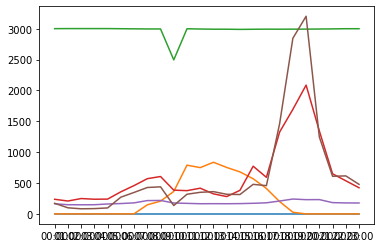

In [29]:
plt.plot(df)